In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sp
from scipy.stats import norm, skew 


In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:

print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))


train_ID = train['Id']
test_ID = test['Id']


train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1030, 81) 
The test data size before dropping Id feature is : (430, 80) 

The train data size after dropping Id feature is : (1030, 80) 
The test data size after dropping Id feature is : (430, 79) 


# 데이터 전처리

- 상관분석을 통해 수치형 데이터중 가장 가격과 상관관계가 큰 특성들의 이상치(outlier)들을 제거한다.

- 지나치게 특이한 행동을 보이는 이상치를 제거함으로써 안전한 모델을 만들수 있다 

- 살펴 본 특성외에도 이상치가 있을 수 있으나, 테스트 데이터에도 어느 정도의 이상치가 있을 수 있으므로, 이상치를 모두 없애기보다는, 지나친 이상치만 제거하고 나머지는 남겨서 이상치에 대해 더 강건한 모델을 구축할 수 있다. 

In [4]:
related_feat = train.corr().iloc[-1, :].sort_values(ascending = False).index[1: 6]

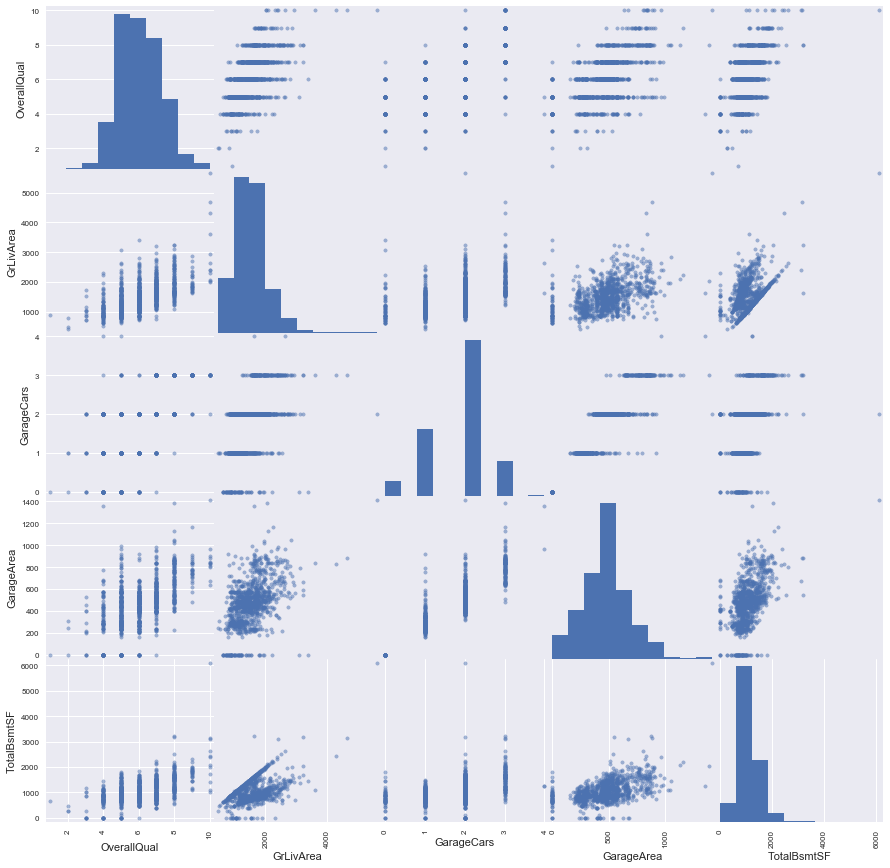

In [5]:
pd.scatter_matrix(train[related_feat], figsize=(15, 15))
plt.show()

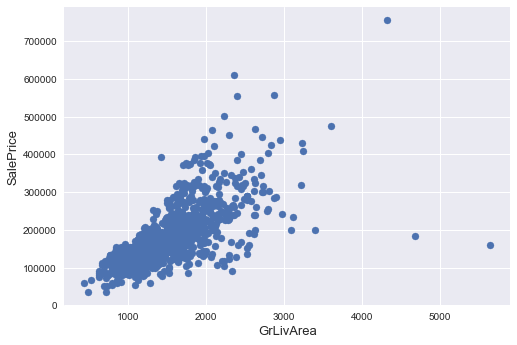

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

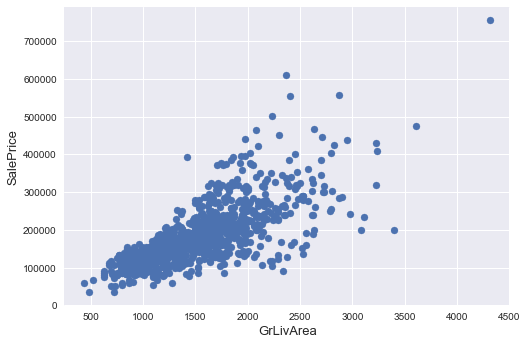

In [7]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# 목적 함수
- SalePrice
- regression에서 데이터들은 skewed 되지않고 정규분포에 가까울수록 좋은 결과가 나오므로
- QQ plot을 통해 정규분포인지 확인한다
- 아래에서는 skewed data이므로 정규분포를 따르게 하기위해 여기서는 log-transformation을 해주었다.

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 181547.39 and sigma = 78105.45



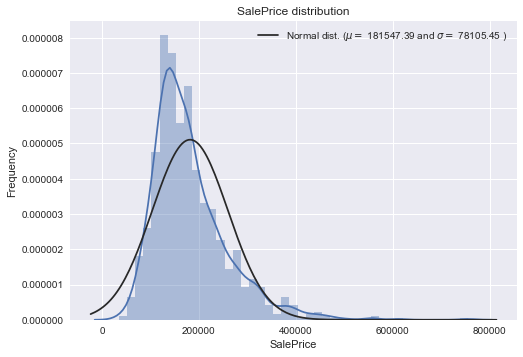

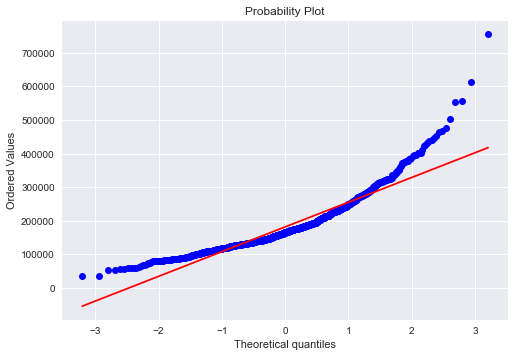

In [8]:
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = sp.norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = sp.probplot(train['SalePrice'], plot=plt)
plt.show()

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 12.03 and sigma = 0.40



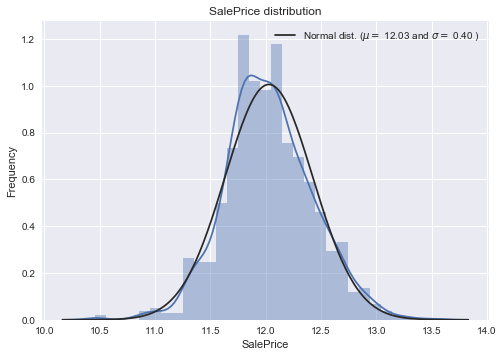

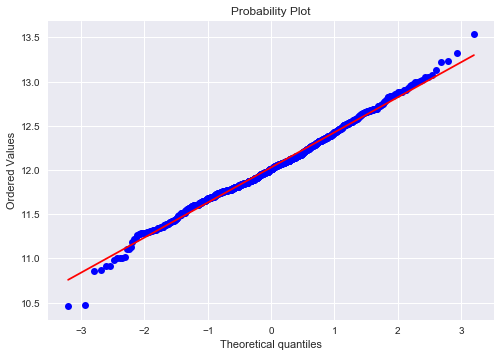

In [9]:

train["SalePrice"] = np.log(train["SalePrice"])


sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = sp.probplot(train['SalePrice'], plot=plt)
plt.show()

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1458, 79)


# Missing Data
- 데이터셋에는 NA로 된 데이터가 많았다. 
- 각 feature별로 isnull()함수를 통해 비어있는 칸을 구하고 그 비율을 구한다.  


In [11]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na[all_data_na > 0].sort_values(ascending = False)
all_data_na

PoolQC          99.588477
MiscFeature     96.296296
Alley           93.758573
Fence           80.727023
FireplaceQu     47.325103
LotFrontage     17.764060
GarageYrBlt      5.555556
GarageType       5.555556
GarageQual       5.555556
GarageFinish     5.555556
GarageCond       5.555556
BsmtFinType2     2.606310
BsmtExposure     2.606310
BsmtQual         2.537723
BsmtFinType1     2.537723
BsmtCond         2.537723
MasVnrArea       0.548697
MasVnrType       0.548697
Electrical       0.068587
dtype: float64

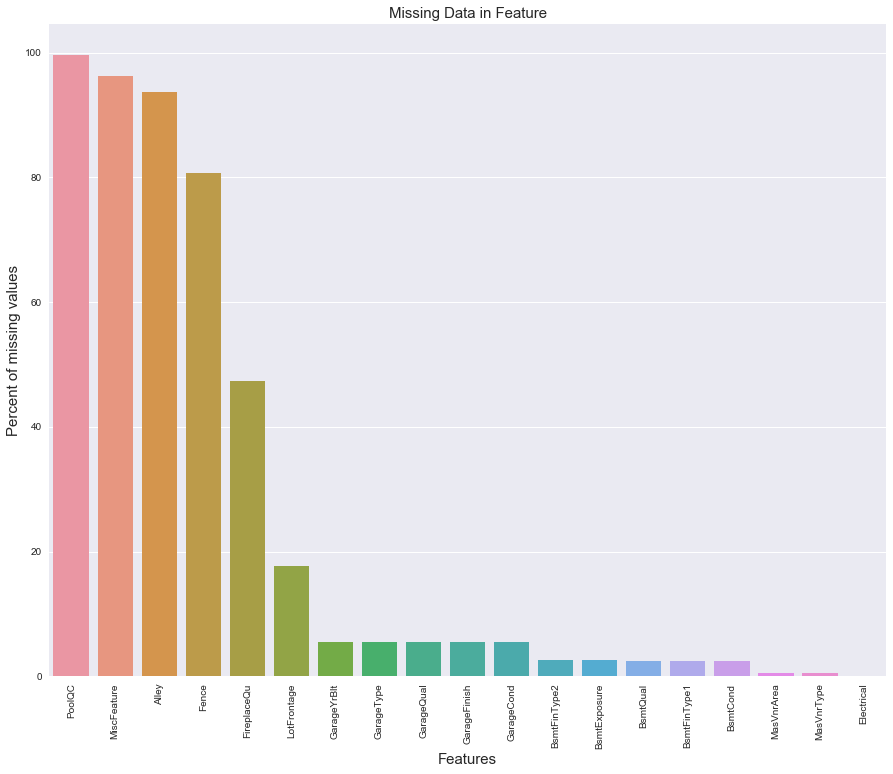

In [12]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Missing Data in Feature', fontsize=15)

# Missing data 채우기

- 데이터가 수치형 데이터(numeric data)와 범주형 데이터(categorical data)가 섞여있으므로 따로 채운다.
- 이를 분석하기 위해서 각 feature들의 의미를 정확히 분석할 필요가 있다.

- 다음은 missing data가 있는 feature들을 모아 Kaggle에서 나온 feature들의 설명을 덧붙인 것이다.

- PoolQC         : Pool quality (풀장의 질, Nan이면 없는것 : /범주형)
- MiscFeature    : Miscellaneous feature not covered in other categories(기타: None /??)
- Alley          : Type of alley access (근접한 골목 종류 Nan이면 없는것 : /범주형
- Fence          : Fence quality (울타리의 질, Nan이면 없는것 :/ 범주형)
- FireplaceQu    : Fireplace quality (난로의 질: Nan이면 없는것 :/ 범주형)
- LotFrontage    : Linear feet of street connected to property (집의 너비 Nan은 임의로 같은 이웃을 가진 index들의 평균값으로 설정 : /수치형)
- GarageYrBlt    : Year garage was built (차고 지어진 년수 Nan이면 없는것 : 0 /수치형)
- GarageType     : Garage location (차고 종류 Nan이면 없는것 : None /범주형)
- GarageQual     : Garage quality  (차고 질 Nan이면 없는것 : None /범주형)
- GarageFinish   : Interior finish of the garage (차고 마감 Nan이면 없는것 : None /범주형)
- GarageCond     : General condition of the basement (차고 상태 Nan이면 없는것 : None/ 범주형)
- BsmtFinType2   : Quality of second finished area (if present) (지하실 없으면 Nan : None/범주형)
- BsmtExposure   : Walkout or garden level basement walls (지하실 없으면 Nan : None/범주형)
- BsmtQual       : Height of the basement (지하실의 높이 지하실 없으면 Nan : None/범주형)
- BsmtFinType1   : Quality of basement finished area (지하실 없으면 Nan: None/범주형)
- BsmtCond       : General condition of the basement (지하실 상태 지하실 없으면 Nan:None /범주형)
- MasVnrArea     : Masonry veneer area in square feet (벽돌 지역 없으면 Nan: 0/수치형
- MasVnrType     : Masonry veneer type (벽돌 지역 없으면 Nan: 0/수치형)
- Electrical     : Electrical system (전기 없으면 Nan:none/범주형)

## None으로 바꿔야할 Features
- 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageFinish', 'GarageCond','BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond', 'MasVnrType', 'Electrical'

In [13]:
to_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
           'GarageType', 'GarageQual', 'GarageFinish', 'GarageCond',
           'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1',
           'BsmtCond', 'MasVnrType', 'Electrical']
all_data[to_none] = all_data[to_none].fillna("None")

## 0으로 바꿔야할 Features
- 'MasVnrArea',' GarageYrBlt'

- LotFrontage는 누락된 것으로 보이므로 이웃들의 평균값으로 가정한다. 

In [14]:
to_zero = ['MasVnrArea','GarageYrBlt']
all_data[to_zero] = all_data[to_zero].fillna(0)


In [15]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [16]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio


## 수치이지만 실제로는 범주형 데이터인 것들
- 건물 클래스는 범주형이다.(MSSubClass)
- 전체적인 건물상태 -> 범주형 (OverallCond)
- 팔린 년도, 월은 범주형 (참고: 시계열 데이터는 범주형도 수치형도 아니고, 분석 목적에 따라 변할 수 있다. 예를 들어 시간에 따라 점차적으로 수치가 변화한다면 수치데이터, 이와같이 특정한 년, 월을 기준으로 한다면 범주형 데이터로 분석한다. (YrSold, MoSold)

In [17]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)



all_data['OverallCond'] = all_data['OverallCond'].astype(str)



all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [18]:
len(all_data.columns)

79

# 상관분석
- 상관분석을 통해서 feature들 간의 상관계수가 너무 높은 것은 제거한다

- 상관계수가 0.8 이상으로 높은 두 개의 특성들은 다른 하나의 특성으로 설명 가능하다.


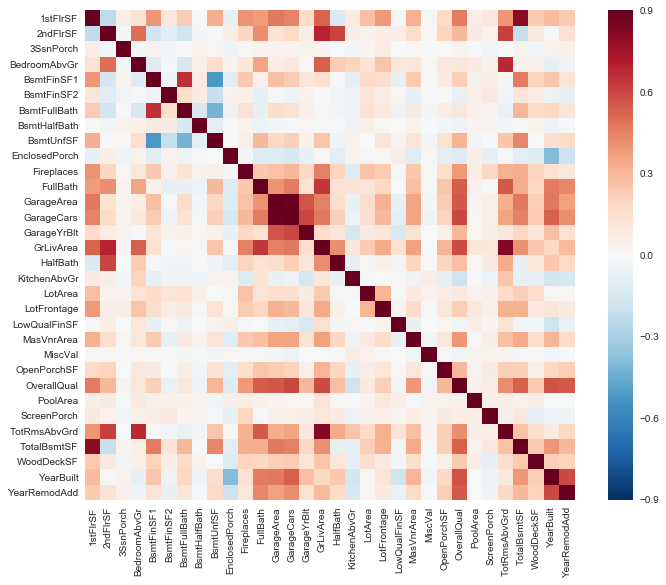

In [19]:
corrmat = all_data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [20]:
for i in corrmat.columns:
    correlated = corrmat[i][(corrmat[i]> 0.85) & (corrmat[i] != 1)]
    if len(correlated) != 0:
        print(correlated.name, '<-->', correlated.index[0])

GarageArea <--> GarageCars
GarageCars <--> GarageArea


## 서로 상관계수가 높은 feature 쌍들
- 더 큰 개념의 feature를 선택한다.
- 만약 상식적으로 접근이 불가능하다면, SalePrice와의 상관계수가 높은 feature을 선택하고, 다른 한쪽을 제거한다.
#### 1stFlrSF <--> TotalBsmtSF
- 1층의 평수 <--> 전체 지하실의 평수
- 전체 지하실의 평수는 1층의 평수를 설명할 수 있는지는 애매하다.
- 그러므로 SalePrice와의 상관계수가 높은 TotalBsmtSF를 선택한다.
#### GarageArea <--> GarageCars
- 차고의 크기(square feet) <--> 차고의 크기(차의 갯수)
- 차의 갯수로따지는 차고의 크기는 차고의 크기(square feet)가 포괄하는 개념이므로 GarageArea를 선택한다.
#### GrLivArea <--> TotRmsAbvGrd
- 윗층(Above Grade)의 생활공간 <--> 윗층의 전체 방수(침실 제외)
- 생활공간은 정체 방수를 포괄하는 개념이므로 GrLivArea를 선택

In [21]:
corr_train = train.corr()
print('TotalBSsmtSF :',corr_train['TotalBsmtSF']['SalePrice'])
print('1stFlrSF :',corr_train['1stFlrSF']['SalePrice'])
print('#'* 40)
print('GarageArea :',corr_train['GarageArea']['SalePrice'])
print('GarageCars :',corr_train['GarageCars']['SalePrice'])
print('#'*40)
print('GrLivArea :',corr_train['GrLivArea']['SalePrice'])
print('TotRmsAbvGrd :',corr_train['TotRmsAbvGrd']['SalePrice'])


TotalBSsmtSF : 0.653715948364
1stFlrSF : 0.621127690289
########################################
GarageArea : 0.670592379418
GarageCars : 0.698805701061
########################################
GrLivArea : 0.72805194571
TotRmsAbvGrd : 0.557748885749


In [22]:
all_data.drop(['GarageCars'], axis = 1, inplace=True)

# 수치형 특성 Skewness 분석

- 각 특성들의 skewness를 분석한다. skewness가 높을수록 feature의 데이터 분포가 왼쪽, 혹은 오른쪽으로 치우쳐진다.

- skewness가 낮을 수록 회귀분석에서 좋은 결과가 나온다. 

- 0.75보다 높은 Skewness를 가진 feature들은 box-cox transformation을 통해 skewness를 낮추어 준다.


In [23]:
#수치형 특성 컬럼들 뽑기 
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
print(len(numeric_feats))

# 수치형 특성들의 skewness를 구하여 정렬
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

31


,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895
EnclosedPorch,3.083987


## BOX-COX transformation
- 수식

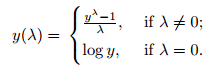

- 비정규분포를 따르는 데이터들을 정규분포처럼 바꿔주는 기법
- 선형모델에서는 정규분포인 데이터에 잘맞는 경우가 많기 때문에 전통적으로 많이 사용된다.


In [24]:
skewness = skewness[abs(skewness) > 0.75].dropna()

transfor = skewness.index

all_data[transfor] = sp.boxcox(1+all_data[transfor], 0.3)


In [25]:
all_data.shape

(1458, 78)

# 추가적인 feature engineering

- 범주형데이터중에 카테고리가 너무 적은 것은 선형모델에 도움이 되지않는다.
- 각 범주형 데이터들의 카테고리의 갯수 분석 실시
- 범주형 데이터의 카테고리당 갯수가 4이하이거나, 1454개 이상으로 너무 적거나 낮은 것은 제외한다.
- pandas의 get_dummies를 사용할 것이므로 그에 맞게 join 함수를 통해 빼야할 특성을 (특성이름_카테고리)로 변환해준다.

In [26]:
# 범주형 데이터 컬럼 뽑기
categorical_feats = all_data.dtypes[all_data.dtypes == "object"].index

sub_feats = []

for i, feat in enumerate(categorical_feats):
    categories = all_data.groupby(feat).count()['2ndFlrSF']
    # 카테고리가 4개 이하이거나, 1454개 이상인
    categories_index = categories[(categories < 4) | (categories > len(all_data) -4)].index
    feature_name = categories_index.name
    for category in categories_index:
        sub_feats.append('_'.join([feature_name, category]))
        
sub_feats

['BsmtCond_Po',
 'Condition1_RRNe',
 'Condition2_Artery',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Electrical_None',
 'ExterCond_Ex',
 'ExterCond_Po',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_AsphShn',
 'Exterior2nd_CBlock',
 'Exterior2nd_Other',
 'Foundation_Wood',
 'Functional_Sev',
 'GarageCond_Ex',
 'GarageQual_Ex',
 'GarageQual_Po',
 'Heating_Floor',
 'Heating_OthW',
 'HeatingQC_Po',
 'MiscFeature_Gar2',
 'MiscFeature_Othr',
 'MiscFeature_TenC',
 'Neighborhood_Blueste',
 'OverallCond_1',
 'PoolQC_Ex',
 'PoolQC_Fa',
 'PoolQC_Gd',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofStyle_Shed',
 'SaleType_Con',
 'SaleType_Oth',
 'Utilities_AllPub',
 'Utilities_NoSeWa']

- Pandas의 get_dummies 명령어를 통해 one-hot encoding 실시
- 앞서 구한 카테고리들을 제외한다.

In [27]:
all_data = pd.get_dummies(all_data)
all_data.drop(sub_feats, axis =1, inplace=True)

### feature engineering이 끝나면 다시 훈련데이터와 테스트 데이터를 원래대로 나눈다.

In [28]:
train = all_data[:ntrain]
test = all_data[ntrain:]
print(train.shape)
print(test.shape)


(1028, 293)
(430, 293)


# Statsmodel의 OLS를 통한 분석


In [29]:
dfX0 = train
const = pd.DataFrame(np.array([1.0 for _ in range(len(train))]), columns = ['const'])
dfX = pd.concat([const, dfX0], axis = 1)

dfy = pd.DataFrame(y_train, columns = ['SalePrice'])

result = sm.OLS(dfy, dfX).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     69.19
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        01:11:35   Log-Likelihood:                 1129.7
No. Observations:                1028   AIC:                            -1741.
Df Residuals:                     769   BIC:                            -463.1
Df Model:                         258                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                     0.11

In [30]:
result.pvalues

const                    8.419619e-01
1stFlrSF                 1.517518e-01
2ndFlrSF                 6.938961e-01
3SsnPorch                1.847706e-01
BedroomAbvGr             1.724649e-01
BsmtFinSF1               3.880523e-01
BsmtFinSF2               7.935315e-01
BsmtFullBath             8.753411e-02
BsmtHalfBath             2.626006e-01
BsmtUnfSF                1.417664e-02
EnclosedPorch            4.717037e-01
Fireplaces               1.212384e-01
FullBath                 2.681205e-02
GarageArea               2.447084e-03
GarageYrBlt              3.928388e-01
GrLivArea                2.208616e-08
HalfBath                 3.144564e-02
KitchenAbvGr             2.507141e-01
LotArea                  3.823348e-14
LotFrontage              8.541005e-01
LowQualFinSF             1.941049e-01
MasVnrArea               3.515173e-01
MiscVal                  1.771859e-01
OpenPorchSF              6.090612e-01
OverallQual              1.317868e-11
PoolArea                 6.739573e-01
ScreenPorch 

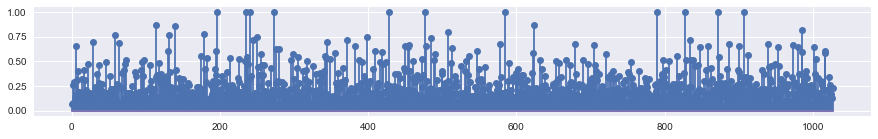

hat.sum() = 259.0


In [31]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(15, 2))
plt.stem(hat)
plt.show()
print("hat.sum() =", hat.sum())

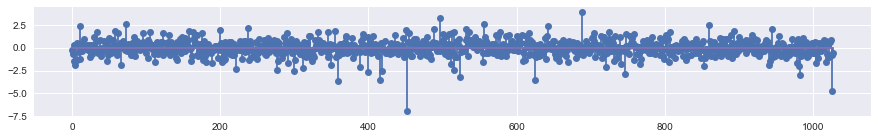

In [32]:
plt.figure(figsize=(15, 2))
plt.stem(result.resid_pearson)
plt.show()

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\POWER USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in greater


[   3    7   34   58   62   66   73   96  105  114  131  139  140  158  179
  181  196  238  239  241  250  259  273  275  276  278  296  299  312  316
  344  349  355  359  372  382  392  399  400  406  415  418  436  448  450
  452  454  455  473  476  478  485  489  496  500  507  512  513  515  524
  532  536  578  584  590  608  623  624  625  657  680  688  690  705  706
  720  721  724  731  746  755  767  798  799  802  827  829  853  859  862
  872  894  900  901  907  941  942  944  949  953  980  981  983  985  986
 1001 1017 1025]


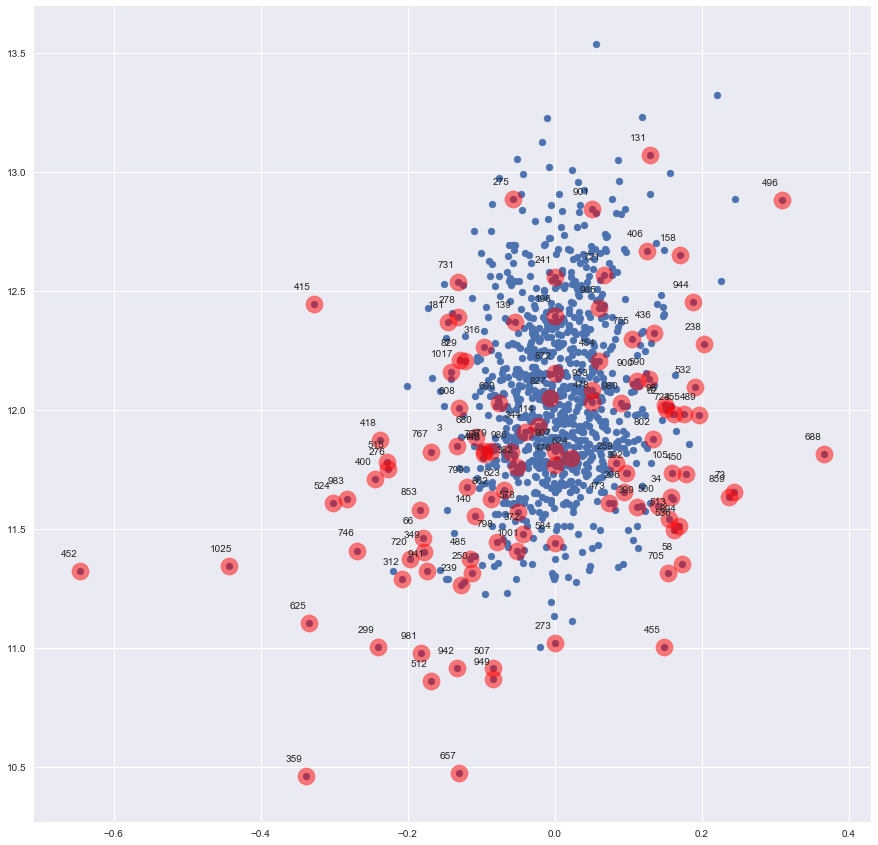

In [33]:
from statsmodels.graphics import utils

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(y_train) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]
print(idx)
plt.figure(figsize=(15, 15))
ax = plt.subplot()
plt.scatter(result.resid, y_train)
plt.scatter(result.resid[idx], y_train[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(result.resid[idx], y_train[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()

# 빼볼까?

In [34]:
df  =pd.concat([train, pd.DataFrame(y_train, columns=['SalesPrice'])], axis=1)
df = df.drop(idx)
df.index = range(len(df))

In [35]:
dfX0 = df.iloc[:,:-1]
const = pd.DataFrame(np.array([1.0 for _ in range(len(df))]), columns = ['const'])
dfX = pd.concat([const, dfX0], axis = 1)

dfy = df.iloc[:, -1]

result_lev = sm.OLS(dfy, dfX).fit()
print(result_lev.summary())

                            OLS Regression Results                            
Dep. Variable:             SalesPrice   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     123.2
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        01:11:41   Log-Likelihood:                 1344.3
No. Observations:                 920   AIC:                            -2211.
Df Residuals:                     681   BIC:                            -1058.
Df Model:                         238                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                     0.38

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# 각 Feature 의 pvalue 분석

In [36]:
pvalues = result_lev.pvalues[1:]
bool_select = pvalues < 0.2
print(bool_select)
feature_columns = train.columns[bool_select]
print(feature_columns)

1stFlrSF                 False
2ndFlrSF                 False
3SsnPorch                 True
BedroomAbvGr              True
BsmtFinSF1               False
BsmtFinSF2               False
BsmtFullBath              True
BsmtHalfBath             False
BsmtUnfSF                 True
EnclosedPorch            False
Fireplaces                True
FullBath                  True
GarageArea                True
GarageYrBlt              False
GrLivArea                 True
HalfBath                  True
KitchenAbvGr             False
LotArea                   True
LotFrontage              False
LowQualFinSF              True
MasVnrArea                True
MiscVal                  False
OpenPorchSF               True
OverallQual               True
PoolArea                  True
ScreenPorch               True
TotRmsAbvGrd             False
TotalBsmtSF               True
WoodDeckSF                True
YearBuilt                 True
                         ...  
PoolQC_None               True
RoofMatl

In [37]:
train_reduct = train[feature_columns]
train_reduct.tail()

,3SsnPorch,BedroomAbvGr,BsmtFullBath,BsmtUnfSF,Fireplaces,FullBath,GarageArea,GrLivArea,HalfBath,LotArea,...,SaleCondition_AdjLand,SaleCondition_Normal,SaleType_COD,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
1023,0.0,4,0,22.294771,0,2,0,28.213286,2,47.854409,...,0,1,0,0,1,0,0,0,1,0
1024,0.0,3,0,27.004193,1,2,840,27.033072,0,48.296919,...,0,0,0,0,1,0,0,0,1,0
1025,0.0,3,0,24.213041,0,1,0,24.213041,0,58.849937,...,0,0,0,0,1,1,0,0,0,0
1026,0.0,2,1,21.540662,0,2,400,24.785682,0,45.130135,...,0,1,0,0,1,0,0,0,1,0
1027,0.0,2,1,0.000000,0,1,240,23.755180,0,49.045017,...,0,1,0,0,1,0,0,0,0,1


In [38]:
dfX0_reduct = dfX[feature_columns]
const = pd.DataFrame(np.array([1.0 for _ in range(len(df))]), columns = ['const'])
dfX_reduct = pd.concat([const, dfX0_reduct], axis = 1)

model_reduct = sm.OLS(dfy, dfX_reduct).fit()
print(model_reduct.summary())

                            OLS Regression Results                            
Dep. Variable:             SalesPrice   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     168.8
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        01:11:41   Log-Likelihood:                 1227.6
No. Observations:                 920   AIC:                            -2151.
Df Residuals:                     768   BIC:                            -1418.
Df Model:                         151                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
const                     0.36

## p값을 통해서 feature를 드랍하는건 R square 값도 오히려 낮아지고 좋은점이 없어보인다.

# 회귀 모델 구축

In [39]:
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge#라소, 엘라스틱넷, 회귀분석
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor #랜덤포레스트, 그래디언트부스
from sklearn.kernel_ridge import KernelRidge #커널 트릭 + 릿지
from sklearn.pipeline import make_pipeline #scaling과 모델 한꺼번에 쓰는 함수
from sklearn.preprocessing import RobustScaler, MinMaxScaler #RobustScaler quantile을 통해서 scaling(outlier 제거기능)
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #모델 합칠때 사용하는 함수들
from sklearn.model_selection import KFold, cross_val_score, train_test_split #교차검증 import
from sklearn.metrics import mean_squared_error #평가방식 MSE

참조: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# 교차검증 함수

- 선형 모델을 parameter로 가지는 교차검증 함수 작성

- n_folds = 5, cross_val_score를 통해 교차검증 계산

- scoring 변수를 neg_mean_squared_error로 하여 parameter로 들어가는 모델의 교차검증을 통해 rmse 5개의 list를 return한다.



In [40]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    print(cross_val_score(model, train.values, y_train, cv=kf))
    return(rmse)

# 선형 모델
- 모든 모델들은 pipeline 함수를 통해 robustscaler를 거치도록 만들었다.
- RobustScale : median값과 quantile를 이용하여 스케일링, outlier에 대해 강건하여 RobustScaling이라고 한다. 
- linear : 일반적인 OLS를 이용한 선형회귀
- lasso : 일반적인 선형회귀에서 사용하는 cost function에 L1 규제를 이용한 정규화 선형회귀, 사용하지 않는 feature들의 coefficient들을 0으로 만들어준다.
- ridge : 일반적인 선형회귀에서 사용하는 cost function에 L2 규제를 이용한 정규화 선형회귀, 사용하지 않는 feature들의 coefficient들을 0에 가깝게 만들어준다.
- ElasticNet : 일반적인 선형회귀에서 사용하는 cost function에 L1규제와 L2 규제를 모두 이용한 정규화 선형회귀, 릿지회귀와 라소회귀의 패널티를 결합한 모델이다.

In [41]:
linear = make_pipeline(RobustScaler(), LinearRegression())

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, max_iter=10000, random_state=1))
#lasso =  Lasso(alpha =0.0005, max_iter=10000, random_state=1)

ridge = make_pipeline(RobustScaler(), Ridge(alpha = 0.6, max_iter = 10000, random_state = 3))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, max_iter=10000, l1_ratio=.9, random_state=3))


KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=1, coef0=11)
#KRR = KernelRidge(alpha=0.6, kernel='linear', degree=2, coef0=3.5)

score = rmsle_cv(linear)
print('linear : {:.4f}({:.4f})\n'.format(score.mean(), score.std()))

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ridge)
print("\nridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))




[ 0.88247084  0.91166452  0.85310391  0.90962798  0.88056417]
linear : 0.1320(0.0126)

[ 0.93384927  0.93557479  0.8987689   0.92870453  0.91984714]

Lasso score: 0.1091 (0.0101)

[ 0.91461027  0.92413139  0.88305992  0.9211388   0.891351  ]

ridge score: 0.1202 (0.0105)

[ 0.93310478  0.93600186  0.89889492  0.92925122  0.91940042]
ElasticNet score: 0.1091 (0.0100)

[ 0.90767796  0.91778964  0.89249353  0.90210514  0.90141729]
Kernel Ridge score: 0.1222 (0.0053)



# 결정트리 회귀모델
- GradientBoost : 여러 개의 결정트리를 묶어 강력한 모델을 만드는 앙상블 기법. 이전에 만든 트리의 예측값과 target값의 오차를 줄이는 방향으로 새로운 트리를 추가하는 알고리즘이다. 오차를 표현하기위해 경사하강법을 통해 손실 함수를 정의하고, learning_rate에 따라서 추가하는 트리의 예측값을 점차적으로 보정해 나간다.
### parameter
- n_estimators : 증가시키면 앙상블에 트리를 많이 추가하여 모델의 복잡도가 올라가나 성능은 올라간다.
- max_depth : 결정트리의 깊이
- min_sample_leaf : 리프 노드가 되기위한 최소 샘플갯수
- min_samples_split : 노드가 분기할 수 있는 최소 샘플 갯수

In [42]:

GBoost = GradientBoostingRegressor(n_estimators=6000, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

#RF = RandomForestRegressor(n_estimators=3000, max_depth=4, max_features='sqrt', min_samples_leaf=15, random_state = 5)


score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

#score = rmsle_cv(RF)
#print('RandomForest score : {:.4f}({:.4f})'.format(score.mean(), score.std()))

[ 0.92645377  0.90776125  0.8825132   0.90575391  0.92944066]
Gradient Boosting score: 0.1182 (0.0142)



# Stacked Regression
- 여러 모델들을 취합하여 과적합을 막고 각 모델들의 장점의 취합하는 모델
- 가장 기본적인 기법으로 averagingModel이 존재
- 각 모델들이 예측한 값들을 평균내는 단순한기법
- 개개의 모델중 가장 좋은 점수보다 더 높은 점수 

In [43]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        self.models_ = [clone(x) for x in self.models]
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [44]:
averaged_models = AveragingModels(models = (ENet, lasso, GBoost))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[ 0.93641625  0.93356901  0.89958451  0.92734226  0.92904325]
 Averaged base models score: 0.1079 (0.0107)



In [45]:
first_prediction = np.zeros(shape = (len(train), len(['a', 'b', 'c'])))
first_prediction.shape

(1028, 3)

# StackNet 기법
- Kaggle Master인 kaz_anova가 고안한 기법
- 각 모델들을 Nerual Network처럼 만들어 쌓는 기법
- 매우 미묘한 차이기는 하지만, average모델보다 약간 더 좋은 성능을 냈다.



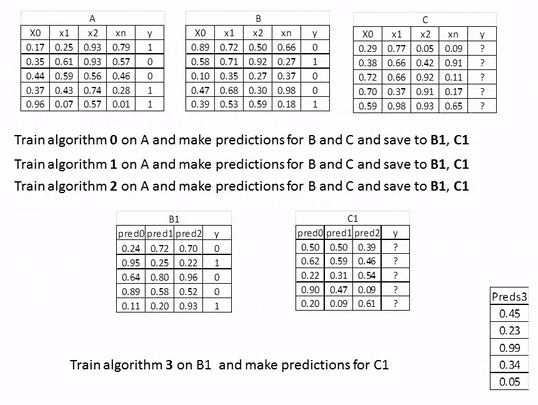

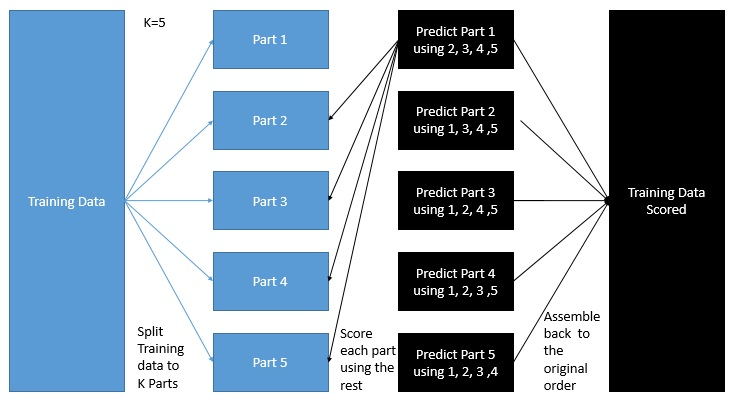

In [46]:
class AverageStackingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, nfolds = 5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
    def fit(self, X, y):
        self.models_ = [[] for _ in self.base_models]
        self.meta = clone(self.meta_model)
        # 데이터 나눌 준비
        kf = KFold(self.n_folds, shuffle = True, random_state = 42)
        # 메타모델을 위한 데이터셋 구축
        meta_feature = np.zeros(shape = (len(X), len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_idx, holdout_idx in kf.split(X, y):
                instance_model = clone(model)
                self.models_[i].append(instance_model)
                instance_model.fit(X[train_idx], y[train_idx])
                meta_feature[holdout_idx, i] = instance_model.predict(X[holdout_idx])
        
        # 메타 모델 트레이닝
        self.meta.fit(meta_feature, y)
        
        return self
    
    def predict(self, X):
        meta_features = np.column_stack(
            [np.column_stack([model.predict(X) for model in base_models]).mean(axis = 1) for base_models in self.models_])
        return self.meta.predict(meta_features)
                

In [47]:
stacked_averaged_model = AverageStackingModel(base_models = (ENet, lasso, GBoost), meta_model= lasso)
score = rmsle_cv(stacked_averaged_model)
print(" Stacked Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[ 0.93428417  0.93541844  0.90029333  0.9278046   0.92886899]
 Stacked Averaged base models score: 0.1078 (0.0102)



In [48]:
stacked_averaged_model = AverageStackingModel(base_models = (ENet, lasso, GBoost), meta_model= ENet)
stacked_averaged_model.fit(train.values, y_train)
predict = stacked_averaged_model.predict(test)
predict = np.exp(predict)
predict

array([ 132115.664287  ,  131108.72236477,  147909.82988333,
        109625.6302644 ,  119275.61422268,  249436.87548801,
        132096.20043096,   93171.9046435 ,  283916.10531467,
        129407.84654871,  145787.36988562,  145678.30582219,
        270956.14153249,  250762.14544776,  128189.00900796,
        101749.71321534,  122984.54290377,  198383.98954926,
        122580.35475798,   94173.65853165,  138806.60282296,
        230853.81282444,  241064.95039321,  141420.14227255,
        104341.42068344,   99655.39868439,  115472.59839284,
        122844.85274362,  261103.22225028,  164979.40664256,
        179420.07247399,  213245.48101512,  185027.23041257,
        161122.0729222 ,  108825.17763508,  143943.10661166,
        223638.50711383,  226272.34932856,  125110.00433331,
        162313.26518178,   87471.9916213 ,  139376.44985359,
        150485.86040099,  210496.85866548,  247559.1904352 ,
        207495.70543713,  222151.62155506,  104914.80446588,
        197027.22129608,

In [52]:
submission = pd.DataFrame()
submission['id'] = test_ID
submission['SalePrice'] = predict
submission.to_csv('Submission.csv', index = False)

,id,SalePrice
0,10,132115.664287
1,13,131108.722365
2,17,147909.829883
3,18,109625.630264
4,20,119275.614223
5,26,249436.875488
6,27,132096.200431
7,31,93171.904643
8,35,283916.105315
9,39,129407.846549


# 특성 계수 분석
- 릿지와 라쏘의 intercept_, coef_ attribute를 통해 어떠한 feature들을 골랐는지 확인 가능하다.

- 그래디언트 부스트에서는 coefficient는 알수 없으나 특성 중요도의 속성을 가지기 때문에 어떠한 특성이 중요한지 알 수있다.

In [49]:
model = lasso.fit(train.values, y_train)
intercept = model.steps[-1][1].intercept_
weights = model.steps[-1][1].coef_

equation = pd.Series(weights, index= train.columns)
equation = pd.concat([pd.Series([intercept], index = ['intercept']), equation])
equation = equation[equation != 0]
print('n of Coefficient in Lasso : ',len(equation))
print('Coefficient in Lasso : \n', equation)

n of Coefficient in Lasso :  125
Coefficient in Lasso : 
 intercept                11.987407
3SsnPorch                 0.000475
BedroomAbvGr             -0.005994
BsmtFinSF1                0.025514
BsmtFinSF2               -0.000055
BsmtFullBath              0.013975
BsmtHalfBath              0.000795
BsmtUnfSF                -0.016802
EnclosedPorch             0.000285
Fireplaces                0.021904
FullBath                  0.018201
GarageArea                0.024065
GarageYrBlt               0.000414
GrLivArea                 0.174853
HalfBath                  0.014793
KitchenAbvGr             -0.036955
LotArea                   0.032834
LotFrontage               0.003078
LowQualFinSF             -0.000658
MiscVal                  -0.002327
OpenPorchSF               0.005590
OverallQual               0.104213
PoolArea                  0.000323
ScreenPorch               0.003059
TotRmsAbvGrd              0.006032
TotalBsmtSF               0.063190
WoodDeckSF                0.0184

In [50]:
model = ENet.fit(train.values, y_train)
intercept = model.steps[-1][1].intercept_
weights = model.steps[-1][1].coef_

equation = pd.Series(weights, index= train.columns)
equation = pd.concat([pd.Series([intercept], index = ['intercept']), equation])
equation = equation[equation != 0]
print('n of Coefficient in ElasticNet : ',len(equation))
print('Coefficient in ElasticNet : \n', equation)

n of Coefficient in ElasticNet :  132
Coefficient in ElasticNet : 
 intercept                11.985355
3SsnPorch                 0.000542
BedroomAbvGr             -0.005935
BsmtFinSF1                0.024616
BsmtFinSF2               -0.000034
BsmtFullBath              0.014177
BsmtHalfBath              0.002590
BsmtUnfSF                -0.017188
EnclosedPorch             0.000319
Fireplaces                0.021619
FullBath                  0.019519
GarageArea                0.024197
GarageYrBlt               0.000402
GrLivArea                 0.174219
HalfBath                  0.015815
KitchenAbvGr             -0.041565
LotArea                   0.033087
LotFrontage               0.003030
LowQualFinSF             -0.000678
MasVnrArea                0.000075
MiscVal                  -0.002584
OpenPorchSF               0.005375
OverallQual               0.102479
PoolArea                  0.000683
ScreenPorch               0.003086
TotRmsAbvGrd              0.006604
TotalBsmtSF           

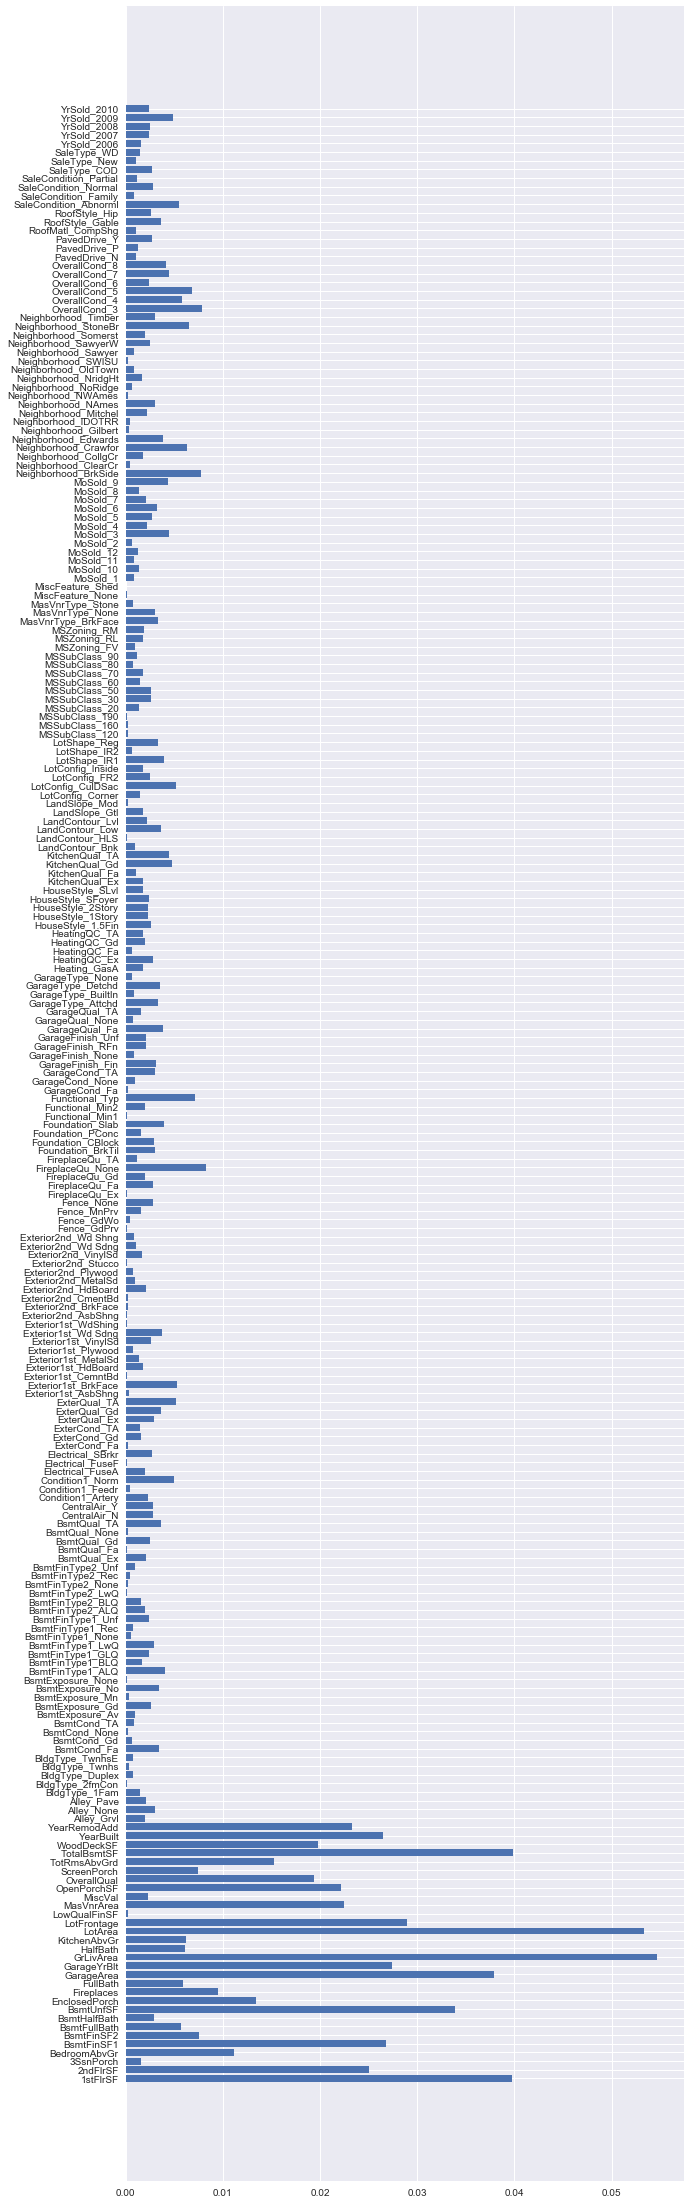

In [69]:
GBoost.fit(train.values, y_train)
importance = GBoost.feature_importances_
fig = plt.figure(figsize=(10, 40))
plt.barh(range(importance[importance > 0].shape[0]), importance[importance > 0], align='center')
plt.yticks(np.arange(importance[importance > 0].shape[0]), train.columns[importance > 0])
plt.show()

# 가격에 영향을 끼치는 중요도 상위 10:
1. LotArea : 전체 평수
2. TotalBsmtSF : 지하실 전체 평수
3. 1stFlrSF : 1층 평수
4. GarageArea : 차고 크기
5. BsmtUnfSF : 지하실 unfinished area 크기
6. LotFrontage : 집의 앞 너비
7. GarageYrBlt : 차고 지어진 년도
8. BsmtFinSF1 : 지하실 finished area 크기
9. YearBuilt : 집 지어진 년도
10. 2ndFlrSF : 2층평수

In [76]:
pd.DataFrame(np.column_stack([train.columns, importance]), columns = ['features', 'importance']).sort_values('importance', ascending=False).head(11)

,features,importance
14,GrLivArea,0.0546924
17,LotArea,0.0533057
27,TotalBsmtSF,0.0399036
0,1stFlrSF,0.0397588
12,GarageArea,0.0378972
8,BsmtUnfSF,0.0338953
18,LotFrontage,0.0289155
13,GarageYrBlt,0.027444
4,BsmtFinSF1,0.0268223
29,YearBuilt,0.0264457
